# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Matplotlib is building the font cache; this may take a moment.


Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Visualize Data

In [3]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
images[0]

'miniature_pinscher_188.jpg'

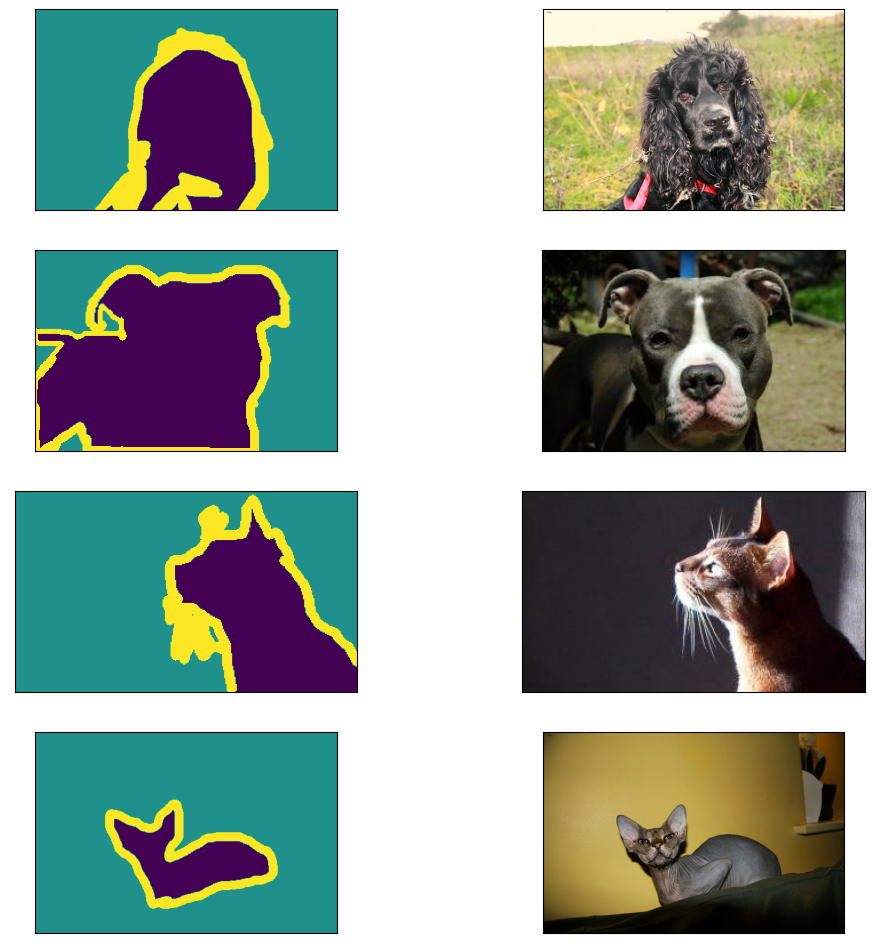

In [6]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [7]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [8]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdataa'
training_image = get_image_uri(boto3.Session().region_name,'semantic-segmentation',repo_version='latest')
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


669576153137.dkr.ecr.eu-north-1.amazonaws.com/semantic-segmentation:1


In [9]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [10]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:19<00:00, 372.29it/s]


In [11]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [12]:
print(len(train_annots), len(train_images))

5534 5534


# Uploading Data to S3

In [13]:
sess = sagemaker.Session()
print('Upload Started!')
s3_train_path = sess.upload_data('train',bucket=bucket_name, key_prefix='train')
print('Training images Uploaded!')
s3_train_annotation_path = sess.upload_data('train_annotation',bucket=bucket_name, key_prefix='train_annotation')
print('Training Annotation images Uploaded!')
s3_validation_path = sess.upload_data('validation',bucket=bucket_name, key_prefix='validation')
print('Validation images Uploaded!')
s3_validation_annotation_path = sess.upload_data('validation_annotation',bucket=bucket_name, key_prefix='validation_annotation')
print('Validation Annotation images Uploaded!')

Upload Started!
Training images Uploaded!
Training Annotation images Uploaded!
Validation images Uploaded!
Validation Annotation images Uploaded!


In [14]:
s3_validation_annotation_path

's3://petsdataa/validation_annotation'

# SageMaker Estimator

In [16]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    train_volume_size=100,
    train_max_run=36000,
    input_mode='File',
    output_path='s3://petsdataa/output',
    sagemaker_session=sess
)
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    crop_size=240,
    num_classes=4,
    epochs=10,
    learning=0.0001,
    optimizer='adam',
    lr_schedule='poly',
    mini_batch_size=16,
    validation_mini_bath_size=16,
    num_training_samples=len(train_images)
)
train_data = sagemaker.session.s3_input(s3_train_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')

validation_data = sagemaker.session.s3_input(s3_validation_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')

train_annotation_data = sagemaker.session.s3_input(s3_train_annotation_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')

validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')

data_channel = {
    'train':train_data,
    'train_annotation':train_annotation_data,
    'validation':validation_data,
    'validation_annotation':validation_annotation_data
}
model.fit(inputs=data_channel,logs=True)

# Hyperparameters

In [ ]:
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    crop_size=240,
    num_classes=4,
    epochs=10,
    learning=0.0001,
    optimizer='adam',
    lr_schedule='poly',
    mini_batch_size=16,
    validation_mini_bath_size=16,
    num_training_samples=len(train_images)
)


# Data Channels

In [ ]:
train_data = sagemaker.session.s3_input(s3_train_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')

validation_data = sagemaker.session.s3_input(s3_validation_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')

train_annotation_data = sagemaker.session.s3_input(s3_train_annotation_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')

validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')

In [ ]:
data_channel = {
    'train':train_data,
    'train_annotation':train_annotation_data,
    'validation':validation_data,
    'validation_annotation':validation_annotation_data
}

# Model Training

In [ ]:
model.fit(inputs=data_channel,logs=True)

# Deploy Model

In [ ]:
deployed_model = model.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

# Predictions

In [ ]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

In [ ]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [ ]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [ ]:
mask = np.array(Image.open(io.BytesIO(results)))

In [ ]:
plt.imshow(plt.imread(image_path));

In [ ]:
plt.imshow(mask);

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)